# 03_train_svm
Trains the SVM on BioCLIP embeddings and writes master predictions + latest pointer files.

**Inputs:**
- `data/processed/class_names_no_ixodes.json`
- `data/processed/final_data_no_ixodes.json`
- image files referenced in the JSON

**Outputs:**
- `results/svm_bioclip/master_predictions*.csv`
- `results/svm_bioclip/master_predictions_latest.csv`
- `results/svm_bioclip/LATEST_MASTER.txt`
- `data/processed/emb_cache/*.npy`


**Run instructions**
- Run Blocks 0–6 (sweep is disabled by default).
- Outputs (per run): `results/svm_bioclip/runs/<RUN_ID>/predictions.csv` and `results/svm_bioclip/runs/<RUN_ID>/analysis/`.
- Outputs (latest): `results/svm_bioclip/latest/predictions.csv` and `results/svm_bioclip/latest/run_id.txt`.


**Note:** Legacy outputs were moved to `results/legacy_svm_bioclip/`. New runs will be written under `results/svm/` in the next refactor step.


In [1]:
import sys
from pathlib import Path
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
from src.utils.paths import load_paths
paths = load_paths()
paths['results_dir'] = paths['results_dir'] / 'legacy_svm_bioclip'


In [2]:
# === 0) Imports & core config ===
# !pip install -q pybioclip scikit-learn pandas numpy pillow torch

import json, random, hashlib, os, time
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image
import torch

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# BioCLIP: used as a feature extractor (image -> embedding vector)
from bioclip.predict import BaseClassifier

# ---- paths (adjust these if needed) ----
CLASS_NAMES = paths['processed_dir'] / 'class_names_no_ixodes.json'   # species list
DATA        = paths['processed_dir'] / 'final_data_no_ixodes.json'    # records: image_path, true_label, sample_id, view

# ---- experiment knobs (global conventions we agreed) ----
SHOTS      = [1, 3, 5]   # K values to sweep
RUNS       = 100             # number of Monte Carlo runs per shots level
BASE_SEED  = 42              # base for deterministic seed derivation
BAND       = "sd"            # "sd" 
MIN_TOTAL  = 30              # species must have >=20 individuals (meeting requirement)

# ---- results locations ----
RESULTS_ROOT = paths['results_dir'] / 'svm_bioclip'
from datetime import datetime
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = Path("results") / "svm_bioclip" / "runs" / RUN_ID
LATEST_DIR = Path("results") / "svm_bioclip" / "latest"
RUN_DIR.mkdir(parents=True, exist_ok=True)
(RUN_DIR / "analysis").mkdir(parents=True, exist_ok=True)
LATEST_DIR.mkdir(parents=True, exist_ok=True)
(LATEST_DIR / "analysis").mkdir(parents=True, exist_ok=True)
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

PLOTS_DIR   = RESULTS_ROOT / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

MASTER = RESULTS_ROOT / "master_predictions.csv"  # single big CSV to append to
RUNS_DIR = RESULTS_ROOT / "runs"                  # optional: per-run JSON caches
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# ---- preview/save controls (you can flip these later) ----
PREVIEW_PLOTS = True   # show plots inline while iterating
SAVE_PLOTS    = False  # set True once finalized PNGs

# ---- per-image embedding cache (under data/processed/) ----
EMB_CACHE = paths['emb_cache_dir']
EMB_CACHE.mkdir(parents=True, exist_ok=True)

# ---- device + model init ----
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
BC = BaseClassifier(device=DEVICE)

# ---- helpers ----
def seed_for(shots: int, run_id: int, base: int = BASE_SEED) -> int:
    """
    Independent few-shot: unique seed per (shots K, run_id).
    Prevents 'growing' the same cohort across K.
    """
    return int(base + 10_000 * shots + run_id)

# optional: fix global RNGs for any non-swept randomness
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# canonical class order placeholder (set after Block 1 once we know retained species)
CLASS_ORDER = None

# ---- run-time banner ----
print("Embedding cache dir:", EMB_CACHE.resolve())
print("Results root dir:   ", RESULTS_ROOT.resolve())
print("Plots dir:          ", PLOTS_DIR.resolve())
print("Master CSV:         ", MASTER.resolve())
print("Device:             ", DEVICE)
print("Config -> SHOTS:", SHOTS, "| RUNS:", RUNS, "| BAND:", BAND, "| MIN_TOTAL:", MIN_TOTAL)


Embedding cache dir: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/emb_cache
Results root dir:    /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/legacy_svm_bioclip/svm_bioclip
Plots dir:           /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/legacy_svm_bioclip/svm_bioclip/plots
Master CSV:          /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/legacy_svm_bioclip/svm_bioclip/master_predictions.csv
Device:              mps
Config -> SHOTS: [1, 3, 5] | RUNS: 100 | BAND: sd | MIN_TOTAL: 30


## 1. Load classes and Specimens

In [3]:
# === Block 1 — Load Classes and Data → Build Specimen Index (clean version) ===

# 1) Load class list and data
with open(CLASS_NAMES, "r") as f:
    SPECIES_LIST = set(json.load(f))

with open(DATA, "r") as f:
    data = json.load(f)  # list of records (image_path, true_label, sample_id, view)

# 2) Build specimen index:
#    by_species[species][sample_id] -> {"dorsal": <path>, "ventral": <path>}
by_species = defaultdict(lambda: defaultdict(dict))
for r in data:
    sp = r["true_label"]
    if sp not in SPECIES_LIST:
        continue
    sid  = r["sample_id"]
    view = str(r["view"]).strip().lower()
    by_species[sp][sid][view] = r["image_path"]

# 3) Keep only specimens with BOTH views
for sp in list(by_species.keys()):
    for sid in list(by_species[sp].keys()):
        views = by_species[sp][sid]
        if not ("dorsal" in views and "ventral" in views):
            del by_species[sp][sid]
    if not by_species[sp]:
        del by_species[sp]

# 4) Enforce ≥ MIN_TOTAL individuals per species
for sp in list(by_species.keys()):
    if len(by_species[sp]) < MIN_TOTAL:
        del by_species[sp]

included_species = sorted(by_species.keys())

# 5) Set canonical class order for downstream plots/matrices
CLASS_ORDER = included_species[:]  # global consistent order

# 6) Print summary
n_specimens = sum(len(smap) for smap in by_species.values())
print(f"Included species: {len(included_species)}")
print(f"Total usable specimens (both views, species ≥ {MIN_TOTAL}): {n_specimens}")
for sp in included_species:
    print(f"  {sp}: {len(by_species[sp])} specimens")

assert len(included_species) > 0, "No species meet the criteria (both views and MIN_TOTAL)."
print("CLASS_ORDER set for downstream use:", CLASS_ORDER)

Included species: 4
Total usable specimens (both views, species ≥ 30): 572
  Amblyomma americanum: 90 specimens
  Dermacentor variabilis: 308 specimens
  Haemaphysalis longicornis: 35 specimens
  Ixodes scapularis: 139 specimens
CLASS_ORDER set for downstream use: ['Amblyomma americanum', 'Dermacentor variabilis', 'Haemaphysalis longicornis', 'Ixodes scapularis']


## Block 2 Train test split

In [4]:
# === Block 2 — Train/Test Split (shots-aware, Seeded, prints) ===
def split_for_run(by_species, species_list, k, run_id):
    """Independent split for this (K=k, run_id) using the new seed_for()."""
    seed = seed_for(k, run_id)         # <- uses your new Block-0 seed_for
    return split_once(by_species, species_list, k=k, seed=seed)

def split_once(by_species, species_list, k, seed):
    rng = random.Random(seed)
    train_pairs, test_pairs = [], []
    per_species_counts = {}

    for sp in species_list:
        sids = list(by_species[sp].keys())
        rng.shuffle(sids)
        tr, te = sids[:k], sids[k:]

        # Sanity checks per your policy
        assert len(tr) == k, f"{sp}: needs exactly {k} train specimens, found {len(tr)}"
        assert len(te) >= 1, f"{sp}: needs at least 1 test specimen (has {len(sids)} total)"

        train_pairs.extend([(sp, sid) for sid in tr])
        test_pairs.extend([(sp, sid) for sid in te])
        per_species_counts[sp] = {"train": len(tr), "test": len(te), "total": len(sids)}

    # No leakage: specimen (sample_id) cannot be in both sets
    assert not (set(train_pairs) & set(test_pairs)), "Leakage detected: same (species, sample_id) in train & test"

    n_test_run = len(test_pairs)
    return train_pairs, test_pairs, per_species_counts, n_test_run


# --- Example single-run preview (keep this pattern for ad-hoc checks) ---
K_demo    = 5          # can use 1 / 3 / 10 too
RUN_demo  = 0          # change this to see different runs at same K

train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    by_species, included_species, k=K_demo, run_id=RUN_demo
)

# ---- Summary prints (unchanged style) ----
n_species = len(included_species)
n_train   = len(train_pairs)
n_test    = len(test_pairs)

print(f"(K, run) = ({K_demo}, {RUN_demo}) | seed = {seed_for(K_demo, RUN_demo)}")
print(f"Species included: {n_species}")
print(f"Train specimens: {n_train}  (expected {K_demo} × {n_species} = {K_demo*n_species})")
print(f"Test specimens:  {n_test}")

for sp in included_species:
    c = split_counts[sp]
    print(f"  {sp}: total={c['total']}, train={c['train']}, test={c['test']}")

# Optional: peek a few chosen IDs per species
for sp in included_species:
    chosen = [sid for (s, sid) in train_pairs if s == sp][:min(3, K_demo)]
    print(f"  Train IDs sample — {sp}: {chosen}")

(K, run) = (5, 0) | seed = 50042
Species included: 4
Train specimens: 20  (expected 5 × 4 = 20)
Test specimens:  552
  Amblyomma americanum: total=90, train=5, test=85
  Dermacentor variabilis: total=308, train=5, test=303
  Haemaphysalis longicornis: total=35, train=5, test=30
  Ixodes scapularis: total=139, train=5, test=134
  Train IDs sample — Amblyomma americanum: ['37-01', 'ZOE-0014-01', 'ZOE-0014-03']
  Train IDs sample — Dermacentor variabilis: ['299-01', '424-01', 'ZOE-0088-02']
  Train IDs sample — Haemaphysalis longicornis: ['47-03', 'OPL-0102-03', '53-05']
  Train IDs sample — Ixodes scapularis: ['250-01', '339-01', '219-01']


## Block 3: Embedding helpers, getting the embeddings and building our Cache. 

In [5]:
# === Block 3 — Embedding Helpers (Per-Image Cache + Specimen Vector) ===

# Per-image cache filename (hash of the image path -> unique + reproducible)
def _cache_fp(img_path: str) -> Path:
    h = hashlib.sha256(img_path.encode("utf-8")).hexdigest()[:24]
    return EMB_CACHE / f"{h}.npy"

# Single-image -> embedding (uses cache if available)
def embed_image(img_path: str) -> np.ndarray:
    """
    Input:  path to an image file
    Output: 1D numpy array (BioCLIP embedding), L2-normalized if normalize=True in create_image_features
    """
    fp = _cache_fp(img_path)
    if fp.exists():
        return np.load(fp)
    pil = Image.open(img_path).convert("RGB")
    vec = BC.create_image_features([pil], normalize=True).cpu().numpy()[0]
    np.save(fp, vec)
    return vec

# Specimen-level vector: average dorsal + ventral embeddings -> one vector per specimen
def specimen_vec(rec: dict) -> np.ndarray:
    """
    rec is: {"dorsal": <path>, "ventral": <path>}
    Returns a single vector for the specimen: 0.5*(z_dorsal + z_ventral)
    """
    z_d = embed_image(rec["dorsal"])
    z_v = embed_image(rec["ventral"])
    return 0.5 * (z_d + z_v)

## Block 4- build X/Y, Train SVM, Metrics, SINGLE SEED

In [6]:
# === Block 4 — Build X/y, Train SVM, Predict, Collect Rows (per run) ===

# helper: turn (species, sample_id) pairs into X (embeddings) and y (labels)
def build_xy(by_species, pairs):
    X, y, ids = [], [], []
    for sp, sid in pairs:
        rec = by_species[sp][sid]          # {"dorsal":..., "ventral":...}
        X.append(specimen_vec(rec))        # averaged dorsal+ventral embedding
        y.append(sp)                       # species label
        ids.append(sid)                    # specimen ID for reporting
    return np.stack(X), np.array(y), ids


def train_predict_collect(by_species,
                          train_pairs, test_pairs,
                          *,
                          shots: int, run_id: int, n_test_run: int):
    """
    Trains the SVM on the given split and collects per-specimen rows for master CSV.
    Returns:
      pred_rows       : list[dict]  (rows for master_predictions.csv)
      per_class_df    : DataFrame  (class_acc, n_test_class)
      macro_acc       : float
      overall_acc     : float
      y_true, y_pred  : np.ndarray, np.ndarray  (for confusion / preview plots)
    """

    # --- Derive the run-specific seed HERE to guarantee independence
    seed = seed_for(shots, run_id)

    # --- Build train/test matrices
    Xtr, ytr, _      = build_xy(by_species, train_pairs)
    Xte, yte, te_ids = build_xy(by_species, test_pairs)

    # --- SVM pipeline (scale → RBF SVM); probability=True to get confidence
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=seed))
    ])

    # --- Train + predict
    clf.fit(Xtr, ytr)
    yhat  = clf.predict(Xte)
    probs = clf.predict_proba(Xte)
    conf  = probs.max(axis=1)   # top-class probability per specimen

    # --- Metrics (overall + macro balanced)
    overall_acc = accuracy_score(yte, yhat)

    tmp = pd.DataFrame({"true": yte, "pred": yhat})
    per_species_acc = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int))
           .groupby("true")["hit"].mean()
    )
    macro_acc = float(per_species_acc.mean())

    # --- Per-class table (for quick prints + later aggregation if needed)
    per_class_df = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
           .groupby("true")
           .agg(class_acc=("hit", "mean"), n_test_class=("one", "sum"))
           .rename_axis("class")
           .reset_index()
    )

    # --- Prepare rows for master CSV (do NOT save here; Block 5 will append)
    pred_rows = []
    for sid, t, p, c in zip(te_ids, yte, yhat, conf):
        pred_rows.append({
            "shots": int(shots),
            "run_id": int(run_id),
            "seed": int(seed),           # keep seed recorded for repro
            "sample_id": str(sid),
            "species_true": str(t),
            "species_pred": str(p),
            "correct": int(t == p),
            "conf_top1": float(c),
            "n_test_run": int(n_test_run)
        })

    # --- Prints (same vibe as your original cell)
    print(f"Seed: {seed} | Shots: {shots} | Run: {run_id}")
    print(f"Overall accuracy: {overall_acc:.3f}")
    print(f"Macro (balanced) accuracy: {macro_acc:.3f}")
    preview = pd.DataFrame({
        "sample_id": te_ids[:10],
        "true_label": yte[:10],
        "pred_label": yhat[:10],
        "pred_confidence": conf[:10]
    })
    display(preview)

    return pred_rows, per_class_df, macro_acc, overall_acc, yte, yhat


In [7]:
# --- one demo run to produce the variables Block 5 needs ---

# tiny helper so we always derive the seed from (K, run_id) in one place
def split_for_run(by_species, species_list, k, run_id):
    return split_once(by_species, species_list, k=k, seed=seed_for(k, run_id))

# pick a shots/run pair (change as you like)
shots  = 5
run_id = 0

# make the split (independent per (K, run))
train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    by_species, included_species, k=shots, run_id=run_id
)

# train & predict (Block 4 now derives seed internally via seed_for(shots, run_id))
pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
    by_species, train_pairs, test_pairs,
    shots=shots, run_id=run_id, n_test_run=n_test_run
)

# quick sanity check so you KNOW they exist
print("pred_rows:", len(pred_rows), "rows")
print("macro_acc:", macro_acc, "overall_acc:", overall_acc)

Seed: 50042 | Shots: 5 | Run: 0
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.463875
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.337792
2,56-02,Amblyomma americanum,Amblyomma americanum,0.361628
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.330213
4,363-01,Amblyomma americanum,Amblyomma americanum,0.349723
5,61-01,Amblyomma americanum,Amblyomma americanum,0.410026
6,50-01,Amblyomma americanum,Amblyomma americanum,0.347528
7,252-01,Amblyomma americanum,Amblyomma americanum,0.362516
8,43-12,Amblyomma americanum,Amblyomma americanum,0.461183
9,241-01,Amblyomma americanum,Amblyomma americanum,0.319889


pred_rows: 552 rows
macro_acc: 0.8043087561609541 overall_acc: 0.8768115942028986


## Block 5 Reporting and saving results for a single seed


Run 0 (seed=50042) — Shots 5 | Overall: 0.877 | Macro: 0.804


,species,n_test,n_correct,accuracy_species,shots,seed
3,Ixodes scapularis,134,126,0.940,5,50042
1,Dermacentor variabilis,303,277,0.914,5,50042
0,Amblyomma americanum,85,62,0.729,5,50042
2,Haemaphysalis longicornis,30,19,0.633,5,50042


[APPEND] shots=5 | run=0 | rows_written=0/552 | macro=0.804 | overall=0.877


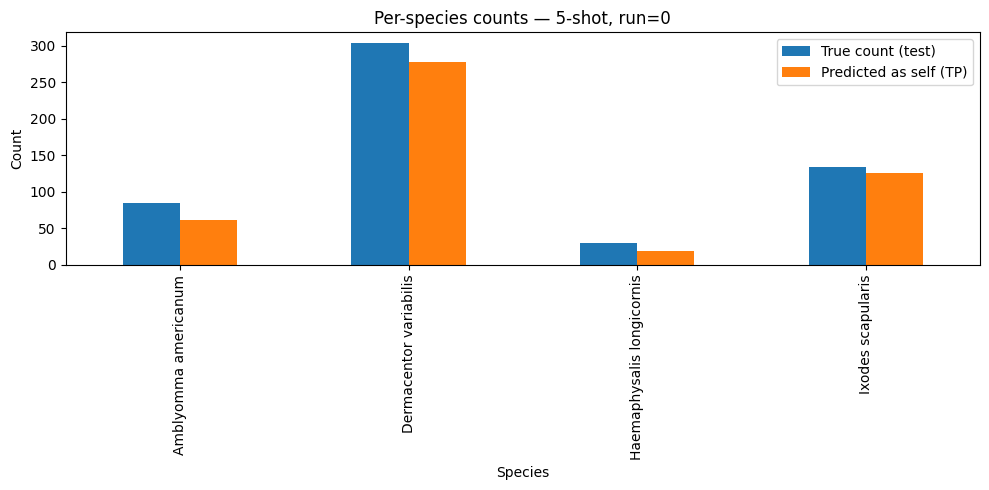


Confusion table (counts) — 5-shot, run=0


pred,Amblyomma americanum,Dermacentor variabilis,Haemaphysalis longicornis,Ixodes scapularis
true,,,,
Amblyomma americanum,62,3,18,2
Dermacentor variabilis,15,277,10,1
Haemaphysalis longicornis,10,0,19,1
Ixodes scapularis,0,1,7,126


In [8]:
# === Block 5 — Single-run reporting + safe append to master CSV ===
# Uses from Block 4: pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred
# Globals: MASTER, CLASS_ORDER (optional), PREVIEW_PLOTS, SAVE_PLOTS, PLOTS_DIR

import matplotlib.pyplot as plt

# ---- 1) Collect run metadata ----
df_run = pd.DataFrame(pred_rows)
shots  = int(df_run["shots"].iloc[0])
run_id = int(df_run["run_id"].iloc[0])

# Prefer the recorded seed; if missing, recompute from (shots, run_id) to keep independence invariant.
if "seed" in df_run.columns and not pd.isna(df_run["seed"].iloc[0]):
    seed = int(df_run["seed"].iloc[0])
else:
    seed = seed_for(shots, run_id)


# ---- 2) Per-species summary table ----
tmp = pd.DataFrame({"true": y_true, "pred": y_pred})
per_species = (
    tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
       .groupby("true")
       .agg(n_test=("one","sum"), n_correct=("hit","sum"))
       .assign(accuracy_species=lambda d: d.n_correct / d.n_test)
       .reset_index()
       .rename(columns={"true": "species"})
)
per_species["shots"] = shots
per_species["seed"]  = seed  # keep for transparency; not used as a key

with pd.option_context('display.float_format', '{:.3f}'.format):
    print(f"\nRun {run_id} (seed={seed}) — Shots {shots} "
          f"| Overall: {overall_acc:.3f} | Macro: {macro_acc:.3f}")
    display(per_species.sort_values("accuracy_species", ascending=False))

# ---- 3) Safe append to master CSV (de-duplicate by (shots, run_id, sample_id)) ----
MASTER.parent.mkdir(parents=True, exist_ok=True)
write_header = not MASTER.exists()

rows_before = len(df_run)
if not write_header:
    keys_existing = pd.read_csv(MASTER, usecols=["shots","run_id","sample_id"])
    merged = df_run.merge(keys_existing.assign(_exists=1),
                          on=["shots","run_id","sample_id"], how="left")
    df_run = merged[merged["_exists"].isna()].drop(columns=["_exists"])

rows_to_write = len(df_run)
if rows_to_write > 0:
    df_run.to_csv(MASTER, mode="a", header=write_header, index=False)

print(f"[APPEND] shots={shots} | run={run_id} | rows_written={rows_to_write}/{rows_before} "
      f"| macro={macro_acc:.3f} | overall={overall_acc:.3f}")

# ---- 5) Optional quick diagnostic plot for this run ----
if PREVIEW_PLOTS:
    # two-bar per-species: True count vs correctly predicted
    plot_df = (
        per_species.set_index("species")[["n_test","n_correct"]]
                   .reindex(CLASS_ORDER, fill_value=0) if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None
                   else per_species.set_index("species")[["n_test","n_correct"]]
    )
    ax = plot_df.plot(kind="bar", figsize=(10,5), color=["#1f77b4", "#ff7f0e"])
    ax.set_title(f"Per-species counts — {shots}-shot, run={run_id}")
    ax.set_xlabel("Species"); ax.set_ylabel("Count")
    ax.legend(["True count (test)", "Predicted as self (TP)"])
    plt.tight_layout()
    if SAVE_PLOTS:
        out = PLOTS_DIR / f"per_species_counts_shots{shots:02d}_run{run_id:03d}.png"
        plt.savefig(out, dpi=150); print(f"[PLOT] saved {out}")
    plt.show()

    # optional plain confusion table for inspection (numbers only)
    conf_tbl = (
        pd.crosstab(pd.Series(y_true, name="true", dtype=object),
                    pd.Series(y_pred, name="pred", dtype=object))
    )
    if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None:
        conf_tbl = conf_tbl.reindex(index=CLASS_ORDER, columns=CLASS_ORDER, fill_value=0)
    else:
        conf_tbl = conf_tbl.fillna(0).astype(int)
    print(f"\nConfusion table (counts) — {shots}-shot, run={run_id}")
    display(conf_tbl.astype(int))


## Block 6 Monte Carlo, 100 seeds. 

In [9]:
# === Block 6 — Monte Carlo sweep (shots × RUNS), timestamped MASTER, plus 'latest' pointer ===
# NOTE: Disabled for per-run outputs. Legacy code preserved below (commented).
ENABLE_SWEEP = False
if ENABLE_SWEEP:
    # # Assumes Blocks 0–5 are loaded.
    # 
    # from tqdm import tqdm
    # import traceback, shutil
    # from datetime import datetime
    # 
    # # --- choose a fresh, timestamped MASTER for this sweep ---
    # timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # MASTER = RESULTS_ROOT / f"master_predictions_{timestamp}.csv"
    # MASTER_LATEST = RESULTS_ROOT / "master_predictions_latest.csv"
    # LATEST_NOTE = RESULTS_ROOT / "LATEST_MASTER.txt"
    # 
    # print(f"[INIT] Writing this sweep to: {MASTER.name}")
    # 
    # # Turn off any preview/saving during the sweep
    # _PREV, _SAVE = globals().get("PREVIEW_PLOTS", False), globals().get("SAVE_PLOTS", False)
    # PREVIEW_PLOTS, SAVE_PLOTS = False, False
    # 
    # failed_runs = []   # (shots, run_id, error_message)
    # total_written = 0  # number of rows appended to MASTER in this sweep
    # 
    # # (optional) helper to keep split seeding consistent in one place
    # def split_for_run(by_species, species_list, k, run_id):
    #     return split_once(by_species, species_list, k=k, seed=seed_for(k, run_id))
    # 
    # for shots in SHOTS:                             # e.g., [1, 3, 5, 10]
    #     pbar = tqdm(range(RUNS), desc=f"{shots}-shot runs", leave=True)
    #     for run_id in pbar:                         # 0..RUNS-1
    #         try:
    #             # 1) Split — seed derived from (shots, run_id) for independence
    #             train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    #                 by_species, included_species, k=shots, run_id=run_id
    #             )
    # 
    #             # 2) Train + predict + collect rows for MASTER
    #             pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
    #                 by_species, train_pairs, test_pairs,
    #                 shots=shots, run_id=run_id, n_test_run=n_test_run
    #             )
    # 
    #             # 3) Append to MASTER (no need to de-dup against previous files; this one is new)
    #             df_run = pd.DataFrame(pred_rows)
    #             df_run["sample_id"] = df_run["sample_id"].astype(str)
    # 
    #             MASTER.parent.mkdir(parents=True, exist_ok=True)
    #             write_header = not MASTER.exists()
    #             if len(df_run) > 0:
    #                 df_run.to_csv(MASTER, mode="a", header=write_header, index=False)
    #                 total_written += len(df_run)
    # 
    #             # Update tqdm summary
    #             pbar.set_postfix(rows_written=len(df_run),
    #                              macro=f"{macro_acc:.3f}", overall=f"{overall_acc:.3f}")
    # 
    #         except Exception as e:
    #             failed_runs.append((shots, run_id, str(e)))
    #             print(f"[ERROR] shots={shots} run_id={run_id} | {e}")
    #             # traceback.print_exc()  # uncomment for deep debugging
    # 
    # # Restore flags
    # PREVIEW_PLOTS, SAVE_PLOTS = _PREV, _SAVE
    # 
    # # --- Sweep summary + sanity checks ---
    # print("\n=== Block 6 sweep complete ===")
    # print(f"MASTER file: {MASTER.name}")
    # print(f"Total rows appended to MASTER in this sweep: {total_written}")
    # if len(failed_runs):
    #     print(f"Failures: {len(failed_runs)}")
    #     for shots_, run_id_, msg in failed_runs[:10]:
    #         print(f"  shots={shots_} run_id={run_id_} -> {msg}")
    #     if len(failed_runs) > 10:
    #         print("  ... (truncated)")
    # 
    # # Quick duplicate sanity check on keys (within this MASTER only)
    # try:
    #     _keys = pd.read_csv(MASTER, usecols=["shots", "run_id", "sample_id"],
    #                         dtype={"shots": int, "run_id": int, "sample_id": str})
    #     n_dupes = _keys.duplicated(subset=["shots", "run_id", "sample_id"]).sum()
    #     print(f"Duplicate rows in MASTER on (shots, run_id, sample_id): {n_dupes}")
    # except Exception as e:
    #     print(f"[WARN] Could not run duplicate check: {e}")
    # 
    # # --- Update "latest" pointer files for downstream blocks ---
    # try:
    #     # Overwrite a stable filename for convenience
    #     shutil.copyfile(MASTER, MASTER_LATEST)
    #     with open(LATEST_NOTE, "w") as f:
    #         f.write(f"{MASTER.name}\n")
    #     print(f"[LATEST] Updated: {MASTER_LATEST.name} and {LATEST_NOTE.name}")
    # except Exception as e:
    #     print(f"[WARN] Could not update latest pointers: {e}")
    # 
    # print("MASTER path:", MASTER.resolve())


SyntaxError: incomplete input (768095372.py, line 97)

## Block 7 Aggregating Results